# EG method to solve elliptic problem 

## Model problem 

$$
\begin{equation}
    \begin{aligned}
        -\nabla \cdot (\mathbf{K} \nabla p) + \alpha p &= f \qquad \text{ in } \Omega, \\
        p &= g_D \qquad \text{on } \Gamma_D, \\
        \mathbf{K} \nabla p \cdot \mathbf{n} &= g_N \qquad \text{on } \Gamma_N.
    \end{aligned}
\end{equation}
$$

## Variational formulation

$$
a_{\epsilon}(u,v) = \sum_{E \in \mathcal{E}_h} \int_E \mathbf{K} \nabla u \cdot \nabla v + \int_{\Omega} \alpha uv 
-  \sum_{e \in \Gamma_h \bigcup \Gamma_D} \int_e \{ \mathbf{K}  \nabla u \cdot \mathbf{n}_e \} [v] 
+ \epsilon \sum_{e \in \Gamma_h \bigcup \Gamma_D} \int_e \{ \mathbf{K}  \nabla v \cdot \mathbf{n}_e \} [u] 
+ \frac{\sigma}{h} \sum_{e \in \Gamma_h \bigcup \Gamma_D}  \int_e [u][v]
$$

$$
L(v) = \int_{\Omega} fv +  \sum_{e\in \Gamma_D} \int_e (\epsilon \mathbf{K} \nabla v \cdot \mathbf{n}_e + \frac{\sigma}{h}v )g_D + \sum_{e\in \Gamma_N} \int_e vg_N
$$

In [2]:
from ngsolve import *
from ngsolve.webgui import Draw

In [3]:
# Define important parameters
epi = -1
sigma = 10
order = 1
alpha = 1
mh=0.1
f = (2+alpha) * sin(x) * sin(y)
dirichlet_bnd = "left|right|top"
gD = sin(x) * sin(y)
# gD = CoefficientFunction([sin(x) * sin(y) if bc!="bottom" else 0 for bc in mesh.GetBoundaries()])
neumann_bnd = 'bottom'
gN = CoefficientFunction(-sin(x) * cos(y))  # 下边界取值


In [4]:
# Define the mesh
mesh = Mesh(unit_square.GenerateMesh(maxh=mh))
Draw(mesh)
print(mesh.Boundaries(neumann_bnd))


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [5]:
# Define the EG space 
Vcg = H1(mesh, order=1)  # 连续线性空间
Vdg = L2(mesh, order=0,dgjumps=True)  # 不连续常数空间（块状加密）
# fes = FESpace([Vcg, Vdg])
fes = Vcg*Vdg
# ucg,vcg = fes.components[0].TnT()
# udg,vdg = fes.components[1].TnT()

In [34]:
ucg,udg = fes.TrialFunction()
vcg,vdg = fes.TestFunction()
a_epi = BilinearForm(fes)
F = LinearForm(fes)
h = specialcf.mesh_size  

coef trial-function diffop = Id, real

coef trial-function diffop = Id, real



In [35]:
jump_u = udg - udg.Other()
jump_v = vdg - vdg.Other()
n = specialcf.normal(2)
mean_dudn = 0.5*n*(grad(udg)+grad(udg.Other()))
mean_dvdn = 0.5*n*(grad(vdg)+grad(vdg.Other()))
a_epi += grad(udg)*grad(vdg)*dx + alpha*udg*vdg*dx \
                + (epi * mean_dvdn * jump_u- mean_dudn * jump_v)*dx(skeleton=True) \
                + sigma/h* jump_u*jump_v*dx(skeleton=True) \
                + (epi * grad(vdg).Trace()*n*udg - grad(udg).Trace()*n*vdg)*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))  \
                + sigma/h*udg*vdg*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))
# Define the right hand side
F += f * vdg*dx \
    + (epi*grad(vdg).Trace()*n + sigma/h*vdg)*gD*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd)) \
    + vdg*gN*ds(skeleton=True,definedon=mesh.Boundaries(neumann_bnd))

In [36]:
a_epi += grad(ucg)*grad(vcg)*dx + alpha*ucg*vcg*dx \
                + (epi * grad(vcg).Trace()*n*ucg - grad(ucg).Trace()*n*vcg)*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))  \
                + sigma/h*ucg*vcg*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))
# Define the right hand side
F += f * vcg*dx \
    + (epi*grad(vcg).Trace()*n + sigma/h*vcg)*gD*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd)) \
    + vcg*gN*ds(skeleton=True,definedon=mesh.Boundaries(neumann_bnd))

In [37]:
a_epi +=  grad(udg)*grad(vcg)*dx + alpha*udg*vcg*dx \
            + (epi * (grad(vcg)*n) * jump_u)*dx(skeleton=True) \
            + (epi * grad(vcg).Trace()*n*udg - grad(udg).Trace()*n*vcg)*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))  \
            + sigma/h*udg*vcg*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))
a_epi += grad(ucg)*grad(vdg)*dx + alpha*ucg*vdg*dx \
                - (grad(ucg)*n * jump_v)*dx(skeleton=True) \
                + (epi * grad(vdg).Trace()*n*ucg - grad(ucg).Trace()*n*vdg)*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))  \
                + sigma/h*ucg*vdg*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))


In [10]:
jump_u = ucg - ucg.Other()
jump_v = vcg - vcg.Other()
# n = specialcf.normal(2)
mean_dudn = 0.5*n*(grad(ucg)+grad(ucg.Other()))
mean_dvdn = 0.5*n*(grad(vcg)+grad(vcg.Other()))
a_epi += grad(ucg)*grad(vcg)*dx + alpha*ucg*vcg*dx \
                + (epi * mean_dvdn * jump_u- mean_dudn * jump_v)*dx(skeleton=True) \
                + sigma/h* jump_u*jump_v*dx(skeleton=True) \
                + (epi * grad(vcg).Trace()*n*ucg - grad(ucg).Trace()*n*vcg)*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))  \
                + sigma/h*ucg*vcg*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd))
# Define the right hand side
F += f * vcg*dx \
    + (epi*grad(vcg).Trace()*n + sigma/h*vcg)*gD*ds(skeleton=True,definedon=mesh.Boundaries(dirichlet_bnd)) \
    + vcg*gN*ds(skeleton=True,definedon=mesh.Boundaries(neumann_bnd))

In [38]:
a_epi.Assemble()
F.Assemble()
print(f"a_epi.mat.height = {a_epi.mat.height}")
print(f"a_epi.mat.width = {a_epi.mat.width}")
print(f"fes.ndof = {fes.ndof}")
print(f"Vcg.ndof = {Vcg.ndof}")
print(f"Vdg.ndof = {Vdg.ndof}")

a_epi.mat.height = 357
a_epi.mat.width = 357
fes.ndof = 357
Vcg.ndof = 133
Vdg.ndof = 224


In [39]:
# Solve
gfu = GridFunction(fes,name="uEG")
gfu.vec.data = a_epi.mat.Inverse()*F.vec
print(f"gfu.vec.size = {gfu.vec.size}")

gfu.vec.size = 357


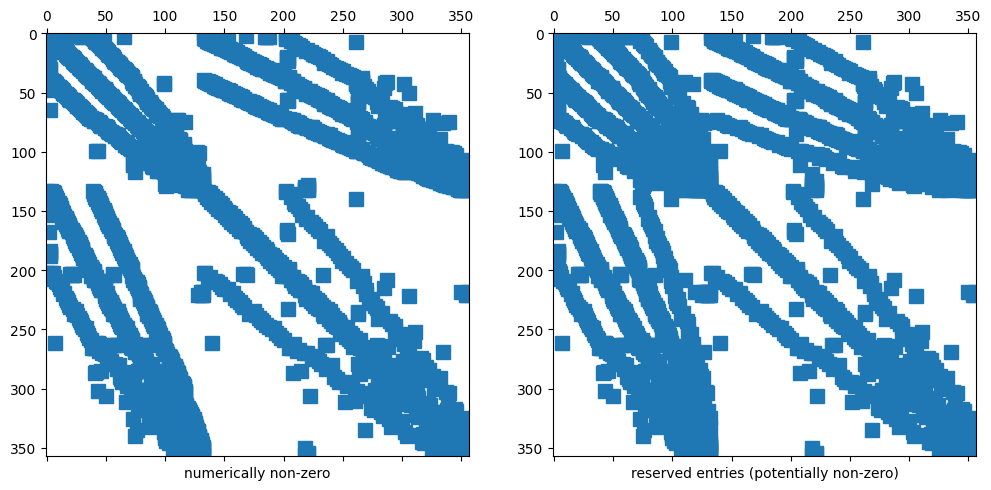

In [40]:
import scipy.sparse as sp
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (12, 12)
A = sp.csr_matrix(a_epi.mat.CSR())
fig = plt.figure(); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.set_xlabel("numerically non-zero"); ax1.spy(A)
ax2.set_xlabel("reserved entries (potentially non-zero)"); ax2.spy(A,precision=-1)
plt.show()

In [41]:
Draw(gfu.components[0],mesh)
Draw(gfu.components[1],mesh)
Draw(gfu.components[0]+gfu.components[1],mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [16]:
Draw(gD,mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [10]:
print(mesh.GetBoundaries())

('bottom', 'right', 'top', 'left')


In [43]:
# L2误差计算
u_exact = sin(x)*sin(y)
err = sqrt(Integrate((gfu.components[0]- u_exact)**2, mesh))
print("L2 error =", err)

L2 error = 0.0014723042850894033


In [24]:
gfu1, gfu2 = gfu.components
u_total = gfu1 + gfu2


In [42]:
# 定义增强有限元解（数值解）
uh_enriched = gfu.components[0] + gfu.components[1]

# 计算 L2 误差
err = sqrt(Integrate((uh_enriched - u_exact)**2, mesh))
print("L2 error (Enriched FEM) =", err)


L2 error (Enriched FEM) = 0.0004887631389847067


In [101]:
print("Neumann RHS contribution =",
      Integrate(gN, mesh, definedon=mesh.Boundaries(neumann_bnd)))

Neumann RHS contribution = -0.4596976977252602


-0.45969769413186023


In [45]:
for edge in mesh.edges:
    print ("dofs = ", fes.GetDofNrs(edge)) 


dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()
dofs =  ()


In [68]:
help(ds)

Help on DifferentialSymbol in module ngsolve.comp object:

class DifferentialSymbol(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      DifferentialSymbol
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __call__(...)
 |      __call__(self: ngsolve.comp.DifferentialSymbol, definedon: Optional[Union[ngsolve.comp.Region, str]] = None, element_boundary: bool = False, element_vb: ngsolve.comp.VorB = <VorB.VOL: 0>, skeleton: bool = False, bonus_intorder: int = 0, intrules: dict[ngsolve.fem.ET, ngsolve.fem.IntegrationRule] = {}, deformation: ngsolve.comp.GridFunction = None, definedonelements: pyngcore.pyngcore.BitArray = None) -> ngsolve.comp.DifferentialSymbol
 |
 |  __init__(...)
 |      __init__(self: ngsolve.comp.DifferentialSymbol, arg0: ngsolve.comp.VorB) -> None
 |
 |  ----------------------------------------------------------------------
 |  Static methods inherited from pybind11_builtins.pybind11_object:
 |
 |

In [111]:
help(specialcf)

Help on SpecialCFCreator in module ngsolve.fem object:

class SpecialCFCreator(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      SpecialCFCreator
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  EdgeCurvature(...)
 |      EdgeCurvature(self: ngsolve.fem.SpecialCFCreator, dim: int) -> ngfem::CoefficientFunction
 |
 |      EdgeCurvature
 |      space-dimension must be provided
 |
 |  EdgeFaceTangentialVectors(...)
 |      EdgeFaceTangentialVectors(self: ngsolve.fem.SpecialCFCreator, dim: int) -> ngfem::CoefficientFunction
 |
 |      EdgeFaceTangentialVectors
 |      space-dimension must be provided
 |
 |  JacobianMatrix(...)
 |      JacobianMatrix(*args, **kwargs)
 |      Overloaded function.
 |
 |      1. JacobianMatrix(self: ngsolve.fem.SpecialCFCreator, dim: int) -> ngfem::CoefficientFunction
 |
 |      Jacobian matrix of transformation to physical element
 |      space-dimension must be provided
 |
 |      2. 

In [116]:
[sin(x) * sin(y) if bc!="bottom" else 0 for bc in mesh.GetBoundaries()]

[0,

In [119]:
Integrate(v * ds('bottom'), mesh)

NgException: cannot evaluate ProxyFunction without userdata